In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
tf.keras.backend.clear_session()

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
subject = 'Rondônia - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Consumo de Cimento (t),Rondônia - Desemprego
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,13.867,8.226062
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,10.777,8.219943
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,13.888,8.213823
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,11.859,8.207703
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,14.431,8.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.931530,NaN,NaN,NaN,NaN,NaN,49.066,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.812259,NaN,NaN,NaN,NaN,NaN,49.850,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.687985,NaN,NaN,NaN,NaN,NaN,43.733,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.551024,NaN,NaN,NaN,NaN,NaN,40.078,NaN


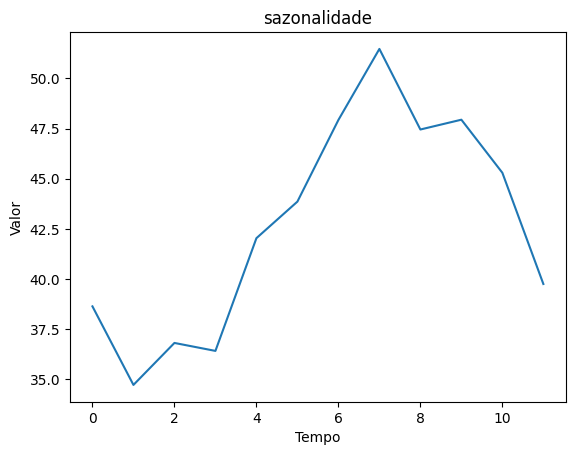

,sazonalidade
sazonalidade,
0,38.640150
1,34.725400
2,36.817425
3,36.420650
4,42.038250
5,43.860500
6,47.928850
7,51.469600
8,47.453850


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,8.226062,38.640150,13.867
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,8.219943,34.725400,10.777
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,8.213823,36.817425,13.888
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,8.207703,36.420650,11.859
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,8.201584,42.038250,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.931530,NaN,NaN,NaN,NaN,NaN,NaN,51.469600,49.066
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.812259,NaN,NaN,NaN,NaN,NaN,NaN,47.453850,49.850
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.687985,NaN,NaN,NaN,NaN,NaN,NaN,47.942450,43.733
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.551024,NaN,NaN,NaN,NaN,NaN,NaN,45.296950,40.078


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Rondônia - Consumo de Cimento (t), Length: 240, dtype: float64

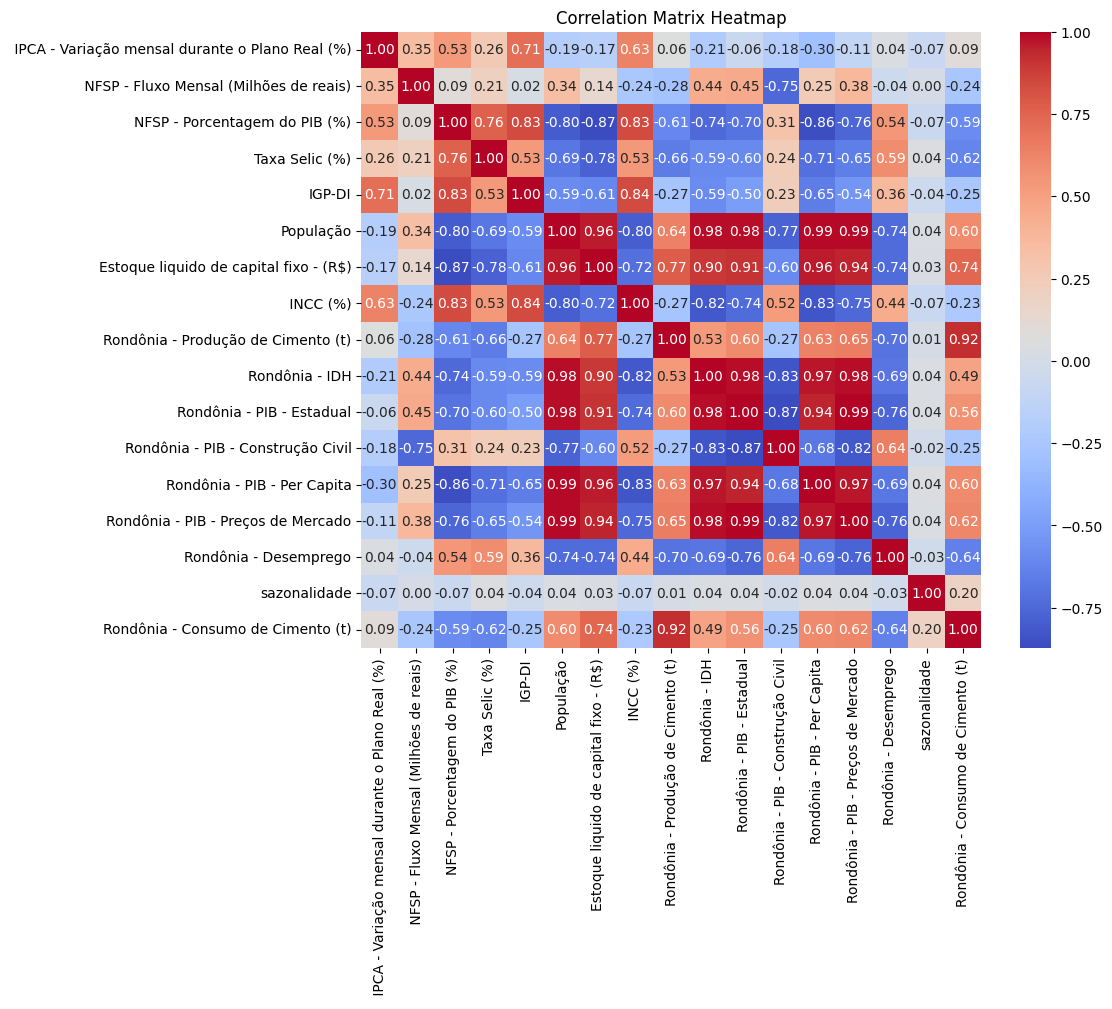

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),1.091838e+03
1,NFSP - Fluxo Mensal (Milhões de reais),2.493156e+02
2,NFSP - Porcentagem do PIB (%),1.855571e+02
3,Taxa Selic (%),5.610255e+01
4,IGP-DI,2.351741e+02
5,População,1.797880e+06
6,Estoque liquido de capital fixo - (R$),6.831948e+05
7,INCC (%),7.089877e+02
8,Rondônia - Produção de Cimento (t),2.225610e+02
9,Rondônia - IDH,3.886029e+06


In [39]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 1


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - Desemprego,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,8.226062,38.640150
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,8.219943,34.725400
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,8.213823,36.817425
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,8.207703,36.420650
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,8.201584,42.038250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,18.811821,0.714578,2.512984e+07,1.460038e+06,11.831960,7.206312,51.469600
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,18.689723,0.714532,2.512400e+07,1.460807e+06,11.831498,7.195485,47.453850
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,18.542721,0.714486,2.511815e+07,1.461577e+06,11.831036,7.184659,47.942450
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,18.336632,0.714440,2.511231e+07,1.462346e+06,11.830574,7.173832,45.296950


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.098891,-1.823039,-1.632278,0.283496,-2.350850,1.189771
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.098891,-1.798540,-1.614104,0.308885,-2.307809,1.176245
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.098891,-1.774041,-1.595929,0.334273,-2.264769,1.162719
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.098891,-1.749542,-1.577755,0.359661,-2.221729,1.149193
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.098891,-1.725043,-1.559580,0.385049,-2.178689,1.135667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,-0.216507,1.544497,1.347401,-1.471890,1.298474,-1.064141
176,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,-0.224300,1.538451,1.343485,-1.461306,1.293839,-1.088071
177,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,-0.233683,1.532406,1.339569,-1.450723,1.289204,-1.112000
178,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,-0.246837,1.526361,1.335653,-1.440140,1.284569,-1.135929


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.098891,-1.823039,-1.632278,0.283496,-2.350850,1.189771
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.098891,-1.798540,-1.614104,0.308885,-2.307809,1.176245
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.098891,-1.774041,-1.595929,0.334273,-2.264769,1.162719
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.098891,-1.749542,-1.577755,0.359661,-2.221729,1.149193
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.098891,-1.725043,-1.559580,0.385049,-2.178689,1.135667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,-0.161674,1.587260,1.348174,-1.572438,1.232992,-0.563646
164,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,-0.158941,1.587171,1.353501,-1.567145,1.252578,-0.630244
165,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,-0.157096,1.587081,1.358829,-1.561852,1.272164,-0.696842
166,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,-0.161536,1.586992,1.364157,-1.556559,1.291749,-0.763439


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
163    39.293
164    41.610
165    43.544
166    35.658
167    29.693
Name: Rondônia - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 13)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - Desemprego
132,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.718677,0.678933,0.983681,-0.991059,0.648927,-0.885224
133,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.671074,0.693440,0.999476,-1.023932,0.666384,-0.817584
134,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.631009,0.707946,1.015272,-1.056805,0.683841,-0.749944
135,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.590391,0.722453,1.031067,-1.089678,0.701298,-0.682304
136,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.548958,0.736959,1.046862,-1.122551,0.718755,-0.614664
137,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.506886,0.751466,1.062657,-1.155424,0.736212,-0.547024
138,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.464614,0.765972,1.078452,-1.188297,0.753669,-0.479384
139,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,0.422280,0.780479,1.094247,-1.221170,0.771126,-0.411744
140,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,0.380004,0.794985,1.110042,-1.254043,0.788584,-0.344104
141,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,0.338080,0.809492,1.125837,-1.286916,0.806041,-0.276464


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 13)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[863889172, 3033727579, 1868906304, 1002609648, 1204205426, 4069952436, 4145105141, 2572944924, 940712505, 329976495]


Step: 0 ___________________________________________
val_loss: 62.93844985961914
winner_seed: 863889172


Step: 1 ___________________________________________
val_loss: 76.96009826660156


Step: 2 ___________________________________________
val_loss: 37.08877182006836
winner_seed: 1868906304


Step: 3 ___________________________________________
val_loss: 50.13775634765625


Step: 4 ___________________________________________
val_loss: 51.278282165527344


Step: 5 ___________________________________________
val_loss: 55.96062088012695


Step: 6 ___________________________________________
val_loss: 59.9361457824707


Step: 7 ___________________________________________
val_loss: 60.54174041748047


Step: 8 ___________________________________________
val_loss: 57.66240310668945


Step: 9 ___________________________________________
val_loss: 44.37766647338867


final_seed: 1

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 134ms/step - loss: 2932.7688 - val_loss: 804.6998
Epoch 2/10000
4/4 [==============================] - 0s 12ms/step - loss: 714.1122 - val_loss: 467.8408
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 483.3234 - val_loss: 628.3475
Epoch 4/10000
4/4 [==============================] - 0s 12ms/step - loss: 459.3250 - val_loss: 413.2070
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 434.8510 - val_loss: 68.4810
Epoch 6/10000
4/4 [==============================] - 0s 12ms/step - loss: 533.1296 - val_loss: 94.5590
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 362.0764 - val_loss: 60.2765
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 290.0950 - val_loss: 147.1724
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 294.8087 - val_loss: 124.5187
Epoch 10/10000
4/4 [==============================] - 0s 11ms/ste

4/4 [==============================] - 0s 12ms/step - loss: 71.4278 - val_loss: 88.5046
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 101.5486 - val_loss: 84.3496
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 82.8876 - val_loss: 59.4630
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 83.2678 - val_loss: 51.4421
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 79.0776 - val_loss: 61.9136
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 78.8577 - val_loss: 74.6532
Epoch 86/10000
4/4 [==============================] - 0s 12ms/step - loss: 74.7749 - val_loss: 55.9551
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss: 79.8778 - val_loss: 89.1027
Epoch 88/10000
4/4 [==============================] - 0s 12ms/step - loss: 95.1232 - val_loss: 77.8068
Epoch 89/10000
4/4 [==============================] - 0s 11ms/step - loss: 76.8079 - va

4/4 [==============================] - 0s 12ms/step - loss: 58.6869 - val_loss: 61.6424
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 57.1959 - val_loss: 56.1958
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.6998 - val_loss: 56.1173
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 59.9929 - val_loss: 62.0878
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 55.8959 - val_loss: 63.8809
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 61.0655 - val_loss: 57.6322
Epoch 165/10000
4/4 [==============================] - 0s 12ms/step - loss: 54.9736 - val_loss: 60.8024
Epoch 166/10000
4/4 [==============================] - 0s 12ms/step - loss: 55.9583 - val_loss: 55.0083
Epoch 167/10000
4/4 [==============================] - 0s 11ms/step - loss: 51.7197 - val_loss: 56.7949
Epoch 168/10000
4/4 [==============================] - 0s 13ms/step - loss: 50.5

Epoch 238/10000
4/4 [==============================] - 0s 12ms/step - loss: 58.9637 - val_loss: 60.6849
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 60.4727 - val_loss: 56.8054
Epoch 240/10000
4/4 [==============================] - 0s 12ms/step - loss: 53.2138 - val_loss: 57.2548
Epoch 241/10000
4/4 [==============================] - 0s 12ms/step - loss: 47.1568 - val_loss: 56.9476
Epoch 242/10000
4/4 [==============================] - 0s 12ms/step - loss: 42.0311 - val_loss: 57.5937
Epoch 243/10000
4/4 [==============================] - 0s 11ms/step - loss: 46.3628 - val_loss: 59.5219
Epoch 244/10000
4/4 [==============================] - 0s 11ms/step - loss: 48.4865 - val_loss: 57.3842
Epoch 245/10000
4/4 [==============================] - 0s 12ms/step - loss: 41.0095 - val_loss: 57.5645
Epoch 246/10000
4/4 [==============================] - 0s 12ms/step - loss: 48.0293 - val_loss: 58.4965
Epoch 247/10000
4/4 [==============================] - 0s 11ms/s

Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.1008 - val_loss: 58.4289
Epoch 318/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.6100 - val_loss: 60.1576
Epoch 319/10000
4/4 [==============================] - 0s 11ms/step - loss: 33.0146 - val_loss: 59.3862
Epoch 320/10000
4/4 [==============================] - 0s 11ms/step - loss: 59.5176 - val_loss: 62.7817
Epoch 321/10000
4/4 [==============================] - 0s 11ms/step - loss: 58.8290 - val_loss: 57.8911
Epoch 322/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.0259 - val_loss: 58.9911
Epoch 323/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.2310 - val_loss: 58.5919
Epoch 324/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.0387 - val_loss: 59.3668
Epoch 325/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.2567 - val_loss: 58.3543
Epoch 326/10000
4/4 [==============================] - 0s 10ms/s

Epoch 396/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.4808 - val_loss: 59.4033
Epoch 397/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.1762 - val_loss: 59.0187
Epoch 398/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.7549 - val_loss: 59.4583
Epoch 399/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.0824 - val_loss: 59.8019
Epoch 400/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.4696 - val_loss: 60.8796
Epoch 401/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.5514 - val_loss: 59.6567
Epoch 402/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.9421 - val_loss: 61.0045
Epoch 403/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.4741 - val_loss: 59.5569
Epoch 404/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.8456 - val_loss: 69.1159
Epoch 405/10000
4/4 [==============================] - 0s 10ms/step 

4/4 [==============================] - 0s 9ms/step - loss: 24.5443 - val_loss: 65.1370
Epoch 476/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.5004 - val_loss: 63.4342
Epoch 477/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.2834 - val_loss: 60.1283
Epoch 478/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.2203 - val_loss: 61.6133
Epoch 479/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.4989 - val_loss: 60.7388
Epoch 480/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.6171 - val_loss: 61.0605
Epoch 481/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.5725 - val_loss: 60.3370
Epoch 482/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.8523 - val_loss: 62.1245
Epoch 483/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.9039 - val_loss: 60.3516
Epoch 484/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.8003 - val

4/4 [==============================] - 0s 9ms/step - loss: 22.2521 - val_loss: 62.6634
Epoch 555/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.6129 - val_loss: 62.0695
Epoch 556/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.2103 - val_loss: 61.0834
Epoch 557/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.8257 - val_loss: 61.5284
Epoch 558/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.2208 - val_loss: 60.2012
Epoch 559/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.5410 - val_loss: 62.8935
Epoch 560/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.2364 - val_loss: 61.4686
Epoch 561/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.9780 - val_loss: 62.9461
Epoch 562/10000
4/4 [==============================] - 0s 8ms/step - loss: 18.1773 - val_loss: 60.7951
Epoch 563/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.7051 - val_

4/4 [==============================] - 0s 9ms/step - loss: 12.9848 - val_loss: 62.3708
Epoch 634/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.7203 - val_loss: 63.9656
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.5324 - val_loss: 60.9566
Epoch 636/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.3215 - val_loss: 60.9940
Epoch 637/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.6894 - val_loss: 63.2908
Epoch 638/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.4836 - val_loss: 66.8617
Epoch 639/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.9112 - val_loss: 65.4456
Epoch 640/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.2072 - val_loss: 63.8153
Epoch 641/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.0809 - val_loss: 61.3588
Epoch 642/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.2648 - va

4/4 [==============================] - 0s 9ms/step - loss: 12.8632 - val_loss: 63.6096
Epoch 713/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3694 - val_loss: 61.6063
Epoch 714/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.6736 - val_loss: 61.7059
Epoch 715/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.5089 - val_loss: 65.2137
Epoch 716/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3578 - val_loss: 64.0385
Epoch 717/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.9025 - val_loss: 65.7288
Epoch 718/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2558 - val_loss: 62.5083
Epoch 719/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.3211 - val_loss: 63.0349
Epoch 720/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.9513 - val_loss: 61.8603
Epoch 721/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.3756 - val_l

4/4 [==============================] - 0s 9ms/step - loss: 10.1952 - val_loss: 62.8852
Epoch 792/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.4356 - val_loss: 63.8229
Epoch 793/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.7397 - val_loss: 60.8868
Epoch 794/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.6700 - val_loss: 63.9061
Epoch 795/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.5623 - val_loss: 61.7971
Epoch 796/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.7030 - val_loss: 64.2287
Epoch 797/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.7695 - val_loss: 62.8611
Epoch 798/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.5074 - val_loss: 64.3662
Epoch 799/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.5952 - val_loss: 62.6722
Epoch 800/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.3327 - val_loss:

4/4 [==============================] - 0s 9ms/step - loss: 8.5322 - val_loss: 63.7011
Epoch 872/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.9962 - val_loss: 65.3114
Epoch 873/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0420 - val_loss: 60.1249
Epoch 874/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.6284 - val_loss: 60.2826
Epoch 875/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6439 - val_loss: 64.8705
Epoch 876/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1256 - val_loss: 64.1155
Epoch 877/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0790 - val_loss: 63.0653
Epoch 878/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.0037 - val_loss: 61.1598
Epoch 879/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.7187 - val_loss: 64.4041
Epoch 880/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3348 - val_loss: 61.3

4/4 [==============================] - 0s 9ms/step - loss: 6.8796 - val_loss: 63.6362
Epoch 952/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.5773 - val_loss: 61.0861
Epoch 953/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.3826 - val_loss: 64.4670
Epoch 954/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4430 - val_loss: 60.6328
Epoch 955/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9947 - val_loss: 59.2861
Epoch 956/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.5808 - val_loss: 63.4809
Epoch 957/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.5812 - val_loss: 64.6496
Epoch 958/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1635 - val_loss: 66.4179
Epoch 959/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7797 - val_loss: 61.6271
Epoch 960/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0635 - val_loss: 6

4/4 [==============================] - 0s 9ms/step - loss: 6.5151 - val_loss: 62.9642
Epoch 1031/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3966 - val_loss: 65.4415
Epoch 1032/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.1402 - val_loss: 62.7260
Epoch 1033/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.6203 - val_loss: 58.7124
Epoch 1034/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.5753 - val_loss: 64.3027
Epoch 1035/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.3742 - val_loss: 62.1791
Epoch 1036/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9532 - val_loss: 60.6756
Epoch 1037/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2580 - val_loss: 62.0180
Epoch 1038/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.1971 - val_loss: 61.1164
Epoch 1039/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8673 - va

4/4 [==============================] - 0s 9ms/step - loss: 5.6201 - val_loss: 61.7977
Epoch 1110/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5649 - val_loss: 62.9669
Epoch 1111/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4394 - val_loss: 65.7171
Epoch 1112/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0436 - val_loss: 63.0526
Epoch 1113/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7354 - val_loss: 60.2347
Epoch 1114/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8862 - val_loss: 61.9537
Epoch 1115/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0425 - val_loss: 60.4558
Epoch 1116/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6536 - val_loss: 64.4835
Epoch 1117/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8237 - val_loss: 61.0354
Epoch 1118/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0610 - val_l

4/4 [==============================] - 0s 9ms/step - loss: 71.9058 - val_loss: 63.0587
Epoch 1189/10000
4/4 [==============================] - 0s 9ms/step - loss: 61.3182 - val_loss: 56.9511
Epoch 1190/10000
4/4 [==============================] - 0s 10ms/step - loss: 57.7267 - val_loss: 58.1861
Epoch 1191/10000
4/4 [==============================] - 0s 10ms/step - loss: 57.5751 - val_loss: 59.3391
Epoch 1192/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.8958 - val_loss: 57.9252
Epoch 1193/10000
4/4 [==============================] - 0s 8ms/step - loss: 61.8284 - val_loss: 75.6283
Epoch 1194/10000
4/4 [==============================] - 0s 9ms/step - loss: 79.2357 - val_loss: 59.2615
Epoch 1195/10000
4/4 [==============================] - 0s 9ms/step - loss: 64.9320 - val_loss: 54.9885
Epoch 1196/10000
4/4 [==============================] - 0s 9ms/step - loss: 65.4918 - val_loss: 58.1525
Epoch 1197/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.

Epoch 1267/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.3347 - val_loss: 61.7697
Epoch 1268/10000
4/4 [==============================] - 0s 10ms/step - loss: 59.6533 - val_loss: 55.0895
Epoch 1269/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.9437 - val_loss: 58.4917
Epoch 1270/10000
4/4 [==============================] - 0s 9ms/step - loss: 64.1603 - val_loss: 57.3423
Epoch 1271/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.9745 - val_loss: 57.5227
Epoch 1272/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.2844 - val_loss: 64.6367
Epoch 1273/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.8880 - val_loss: 57.2012
Epoch 1274/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.5532 - val_loss: 57.8584
Epoch 1275/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.0018 - val_loss: 56.4229
Epoch 1276/10000
4/4 [==============================] - 0s 9ms/

4/4 [==============================] - 0s 9ms/step - loss: 34.5317 - val_loss: 59.4386
Epoch 1346/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.6243 - val_loss: 59.4178
Epoch 1347/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.1480 - val_loss: 57.5170
Epoch 1348/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.4379 - val_loss: 55.7408
Epoch 1349/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.0527 - val_loss: 55.4616
Epoch 1350/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.9233 - val_loss: 53.9861
Epoch 1351/10000
4/4 [==============================] - 0s 9ms/step - loss: 48.2888 - val_loss: 54.8209
Epoch 1352/10000
4/4 [==============================] - 0s 8ms/step - loss: 37.7742 - val_loss: 56.2423
Epoch 1353/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.0799 - val_loss: 55.8236
Epoch 1354/10000
4/4 [==============================] - 0s 9ms/step - loss: 30.95

Epoch 1424/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.2465 - val_loss: 52.2694
Epoch 1425/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.9861 - val_loss: 53.5628
Epoch 1426/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.2643 - val_loss: 53.4290
Epoch 1427/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.7720 - val_loss: 53.6611
Epoch 1428/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.4178 - val_loss: 53.1950
Epoch 1429/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.4505 - val_loss: 52.4327
Epoch 1430/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.1462 - val_loss: 53.5714
Epoch 1431/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.1100 - val_loss: 54.6276
Epoch 1432/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.0982 - val_loss: 53.4303
Epoch 1433/10000
4/4 [==============================] - 0s 9ms/

4/4 [==============================] - 0s 9ms/step - loss: 18.2355 - val_loss: 55.9142
Epoch 1503/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.1590 - val_loss: 55.2214
Epoch 1504/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.0495 - val_loss: 55.1546
Epoch 1505/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.8167 - val_loss: 54.5719
Epoch 1506/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.1031 - val_loss: 55.1261
Epoch 1507/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.9843 - val_loss: 55.0552
Epoch 1508/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.8714 - val_loss: 55.1665
Epoch 1509/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.7586 - val_loss: 56.0728
Epoch 1510/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.4319 - val_loss: 55.2594
Epoch 1511/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.80

Epoch 1581/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.5139 - val_loss: 54.4643
Epoch 1582/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.4601 - val_loss: 53.7799
Epoch 1583/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.0783 - val_loss: 54.4734
Epoch 1584/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6115 - val_loss: 54.4412
Epoch 1585/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.4989 - val_loss: 55.4078
Epoch 1586/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9616 - val_loss: 55.3299
Epoch 1587/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.7672 - val_loss: 53.7632
Epoch 1588/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.8818 - val_loss: 56.0089
Epoch 1589/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7837 - val_loss: 53.9144
Epoch 1590/10000
4/4 [==============================] - 0s 9ms/s

4/4 [==============================] - 0s 9ms/step - loss: 8.8417 - val_loss: 53.0735
Epoch 1661/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.7479 - val_loss: 54.7570
Epoch 1662/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.5835 - val_loss: 57.4059
Epoch 1663/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.7019 - val_loss: 51.0099
Epoch 1664/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6803 - val_loss: 53.2983
Epoch 1665/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1747 - val_loss: 52.5687
Epoch 1666/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.3672 - val_loss: 52.7239
Epoch 1667/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.1555 - val_loss: 53.9280
Epoch 1668/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.4373 - val_loss: 54.0017
Epoch 1669/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.2546 - val

4/4 [==============================] - 0s 8ms/step - loss: 8.6236 - val_loss: 57.0179
Epoch 1740/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.2520 - val_loss: 60.7744
Epoch 1741/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.6436 - val_loss: 62.4424
Epoch 1742/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.9013 - val_loss: 62.5910
Epoch 1743/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.0153 - val_loss: 62.4894
Epoch 1744/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6907 - val_loss: 61.8228
Epoch 1745/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8556 - val_loss: 57.5753
Epoch 1746/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.2567 - val_loss: 64.6687
Epoch 1747/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.2742 - val_loss: 64.7918
Epoch 1748/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.5695 - val_

4/4 [==============================] - 0s 9ms/step - loss: 5.8099 - val_loss: 58.5317
Epoch 1819/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2501 - val_loss: 59.1039
Epoch 1820/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.1995 - val_loss: 57.9980
Epoch 1821/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.5219 - val_loss: 66.5676
Epoch 1822/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9640 - val_loss: 65.2314
Epoch 1823/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.0657 - val_loss: 64.2022
Epoch 1824/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.4789 - val_loss: 66.3100
Epoch 1825/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0358 - val_loss: 59.4790
Epoch 1826/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.1063 - val_loss: 66.5157
Epoch 1827/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8325 - va

4/4 [==============================] - 0s 9ms/step - loss: 5.2046 - val_loss: 65.9879
Epoch 1898/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2514 - val_loss: 66.1649
Epoch 1899/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3537 - val_loss: 57.4119
Epoch 1900/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9742 - val_loss: 37.0888
Epoch 1901/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4454 - val_loss: 56.2613
Epoch 1902/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1814 - val_loss: 56.5797
Epoch 1903/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3183 - val_loss: 57.6939
Epoch 1904/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2850 - val_loss: 69.5246
Epoch 1905/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8546 - val_loss: 52.0364
Epoch 1906/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.8208 - val_

4/4 [==============================] - 0s 9ms/step - loss: 5.1488 - val_loss: 60.4351
Epoch 1977/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7598 - val_loss: 65.0198
Epoch 1978/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5565 - val_loss: 58.3172
Epoch 1979/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4785 - val_loss: 58.8903
Epoch 1980/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0482 - val_loss: 60.2262
Epoch 1981/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7328 - val_loss: 67.8350
Epoch 1982/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0807 - val_loss: 66.1584
Epoch 1983/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8448 - val_loss: 71.1753
Epoch 1984/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8330 - val_loss: 84.3401
Epoch 1985/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5581 - va

4/4 [==============================] - 0s 9ms/step - loss: 4.7170 - val_loss: 79.5063
Epoch 2056/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0701 - val_loss: 81.7667
Epoch 2057/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2451 - val_loss: 77.6638
Epoch 2058/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6133 - val_loss: 81.9815
Epoch 2059/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8511 - val_loss: 77.0848
Epoch 2060/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5673 - val_loss: 66.5234
Epoch 2061/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3341 - val_loss: 78.6905
Epoch 2062/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7955 - val_loss: 70.4895
Epoch 2063/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5003 - val_loss: 71.7890
Epoch 2064/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.1652 - val_

4/4 [==============================] - 0s 9ms/step - loss: 4.3177 - val_loss: 81.9272
Epoch 2135/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3502 - val_loss: 58.1525
Epoch 2136/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8953 - val_loss: 74.0943
Epoch 2137/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2681 - val_loss: 85.4796
Epoch 2138/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1690 - val_loss: 81.2662
Epoch 2139/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0258 - val_loss: 81.3721
Epoch 2140/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1395 - val_loss: 70.0336
Epoch 2141/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9927 - val_loss: 79.7342
Epoch 2142/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4334 - val_loss: 80.3491
Epoch 2143/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8114 - val

4/4 [==============================] - 0s 9ms/step - loss: 4.3474 - val_loss: 76.8477
Epoch 2214/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7848 - val_loss: 64.5433
Epoch 2215/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2739 - val_loss: 71.6858
Epoch 2216/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8845 - val_loss: 75.1854
Epoch 2217/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2033 - val_loss: 66.1217
Epoch 2218/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0063 - val_loss: 78.6171
Epoch 2219/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6653 - val_loss: 77.9821
Epoch 2220/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3625 - val_loss: 80.5392
Epoch 2221/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1418 - val_loss: 82.3330
Epoch 2222/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9506 - val_

4/4 [==============================] - 0s 10ms/step - loss: 4.2207 - val_loss: 89.2526
Epoch 2293/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8048 - val_loss: 91.3503
Epoch 2294/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7938 - val_loss: 56.5716
Epoch 2295/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9269 - val_loss: 70.1360
Epoch 2296/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8828 - val_loss: 66.9603
Epoch 2297/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6901 - val_loss: 66.3998
Epoch 2298/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4684 - val_loss: 87.0247
Epoch 2299/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6568 - val_loss: 73.1630
Epoch 2300/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6376 - val_loss: 78.8793
Epoch 2301/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8027 - val

4/4 [==============================] - 0s 9ms/step - loss: 3.8976 - val_loss: 61.8456
Epoch 2372/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.3387 - val_loss: 74.1945
Epoch 2373/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4764 - val_loss: 71.2153
Epoch 2374/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6451 - val_loss: 79.4911
Epoch 2375/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0828 - val_loss: 76.5034
Epoch 2376/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5068 - val_loss: 76.8135
Epoch 2377/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2178 - val_loss: 78.3267
Epoch 2378/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1991 - val_loss: 56.4764
Epoch 2379/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8478 - val_loss: 67.6973
Epoch 2380/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6157 - va

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,29.369425,28.523489,28.00005,27.810148,27.87307,27.91453,28.585161,29.4634,29.531805,29.509825,29.747383,30.318777
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,3.189573,3.613489,0.71295,4.849852,3.76193,7.227468,7.833838,10.836599,5.961195,8.979174,5.843616,2.788776


In [54]:
display(mae)
display(mape)

5.466538

0.15763886

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[346.64706]] - Target[399.4409999999999]| =  Error: [[52.793945]]; MAPE:[[0.13216957]]


[array([[52.793945]], dtype=float32)]

52.793945

0.13216957